<a href="https://colab.research.google.com/github/sway-am/interpretability_PV_detection/blob/main/LIME_on_PV_v1.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!ls

drive  gdrive  sample_data


In [6]:
%cd /content/gdrive/MyDrive/project_folder

/content/gdrive/MyDrive/project_folder


In [7]:
! git clone https://github.com/zae-bayern/elpv-dataset.git

Cloning into 'elpv-dataset'...
remote: Enumerating objects: 2695, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2695 (delta 2), reused 1 (delta 1), pack-reused 2691
Receiving objects: 100% (2695/2695), 90.79 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Updating files: 100% (2629/2629), done.


In [8]:
#code copied from the utils file
from PIL import Image
import numpy as np
import os


def load_dataset(fname=None):
    if fname is None:
        # Assume we are in the utils folder and get the absolute path to the
        # parent directory.
        __file__ = '/content/gdrive/MyDrive/project_folder/elpv-dataset/doc'
        fname = os.path.abspath(os.path.join(__file__,
                                             os.path.pardir))
        fname = os.path.join(fname, 'labels.csv')

    data = np.genfromtxt(fname, dtype=['|S19', '<f8', '|S4'], names=[
                         'path', 'probability', 'type'])
    image_fnames = np.char.decode(data['path'])
    probs = data['probability']
    types = np.char.decode(data['type'])

    def load_cell_image(fname):
        with Image.open(fname) as image:
            return np.asarray(image)

    dir = os.path.dirname(fname)

    images = np.array([load_cell_image(os.path.join(dir, fn))
                       for fn in image_fnames])

    return images, probs, types

In [9]:
images, proba, types = load_dataset()

In [10]:
np.unique(types,return_counts=True)

(array(['mono', 'poly'], dtype='<U4'), array([1074, 1550]))

In [11]:
import cv2
import numpy as np



# Create an empty numpy array to store the resized images
resized_images = np.empty((2624, 120, 120))

# Loop through each image in the 'images' array and resize it
for i in range(images.shape[0]):
    # Resize the image using OpenCV
    resized_image = cv2.resize(images[i], (120, 120))

    # Store the resized image in the new array
    resized_images[i] = resized_image

del images

images = resized_images


In [12]:
images.shape

(2624, 120, 120)

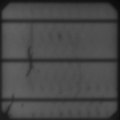

1.0


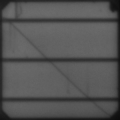

1.0


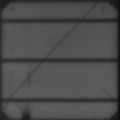

1.0


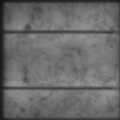

0.0


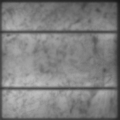

0.0


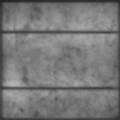

0.0


In [13]:
import cv2 as cv
from google.colab.patches import cv2_imshow
# Becuse cv.imshow causes error " suggesting to use te above"
temp = []
for i in range(63):
  if types[i] == 'poly' :
    temp.append(i)

for i in range(3):
  cv2_imshow(images[i])
  print(proba[i])

for i in temp:
  cv2_imshow(images[i])
  print(proba[i])

In [14]:
np.unique(proba,return_counts=True)

(array([0.        , 0.33333333, 0.66666667, 1.        ]),
 array([1508,  295,  106,  715]))

In [15]:
new_types = []
for i in range(types.shape[0]):
  if types[i] == "mono":
    new_types.append(0)
  else:
    new_types.append(1)

In [16]:
new_types =np.array(new_types)

In [17]:
types = new_types
types

array([0, 0, 0, ..., 1, 1, 1])

###Checking if the model can disnguish between the two panels, to do so it must focus at the corners and check if it is full or cutout

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( images, types, test_size=0.2, random_state=42)

In [19]:
X_train.shape

(2099, 120, 120)

In [20]:
X_test.shape

(525, 120, 120)

In [21]:
X_train = X_train.reshape((-1,120,120,1)).astype('float32') / 255.0
X_test = X_test.reshape((-1,120,120,1)).astype('float32') / 255.0

In [22]:
X_train.shape

(2099, 120, 120, 1)

In [23]:
import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 120,120, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb
X_train = to_rgb(X_train)
X_test = to_rgb(X_test)

In [24]:
X_train.shape

(2099, 120, 120, 3)

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

In [27]:
model = Sequential()

model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
#model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
#model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 16 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1 , activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0

In [28]:
# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='Adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

In [29]:
history = model.fit(X_train,y_train, batch_size = 16 ,epochs = 10 ,validation_data = (X_test, y_test))

Epoch 1/10
132/132 [==============================] - 15s 14ms/step - loss: 0.6083 - accuracy: 0.6112 - val_loss: 0.4170 - val_accuracy: 0.9162
Epoch 2/10
132/132 [==============================] - 1s 7ms/step - loss: 0.2964 - accuracy: 0.9081 - val_loss: 0.0897 - val_accuracy: 0.9981
Epoch 3/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1676 - accuracy: 0.9647 - val_loss: 0.0229 - val_accuracy: 1.0000
Epoch 4/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1512 - accuracy: 0.9752 - val_loss: 0.0223 - val_accuracy: 0.9943
Epoch 5/10
132/132 [==============================] - 1s 8ms/step - loss: 0.1353 - accuracy: 0.9809 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 6/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1304 - accuracy: 0.9795 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 7/10
132/132 [==============================] - 1s 7ms/step - loss: 0.1254 - accuracy: 0.9800 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoc

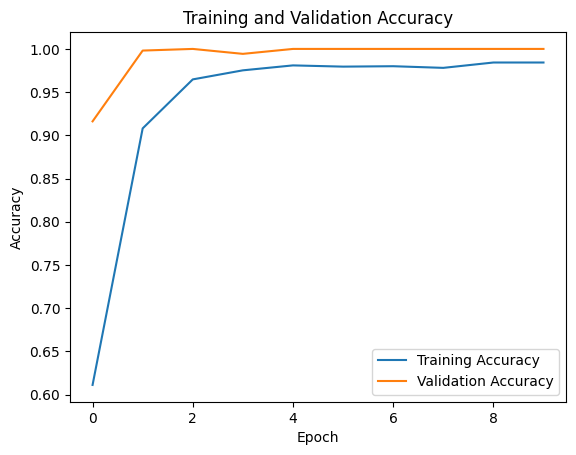

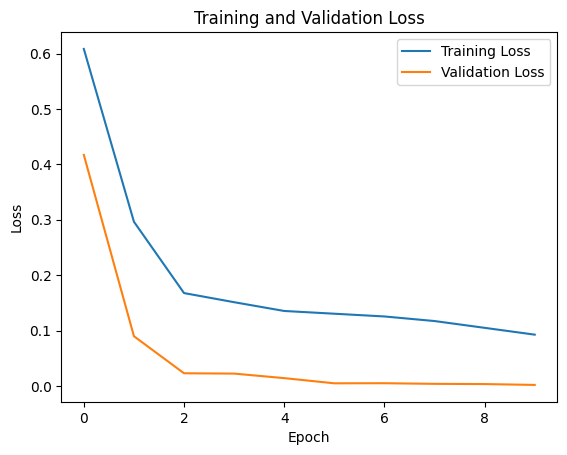

In [30]:
# Plot the training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
predictions = predictions.reshape(1, -1)[0]

17/17 [==============================] - 0s 4ms/step


In [32]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, predictions, target_names = ['mono','poly']))

              precision    recall  f1-score   support

        mono       1.00      1.00      1.00       216
        poly       1.00      1.00      1.00       309

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



In [33]:
model.save("interpretability_PV_test2_types.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
model.save('interpretability_PV_test2_types.keras')

##USING LIME

In [35]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=794114a1f5814e3a73c287789b6ed0f7bc86d506a1d8c6f2e4c7943f26012258
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [36]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 247ms/step


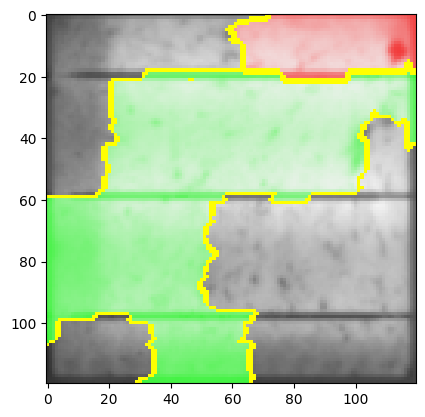

In [37]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_train[60],
         model.predict
)
plt.imshow(X_train[60])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_train[60].reshape((1,120,120,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


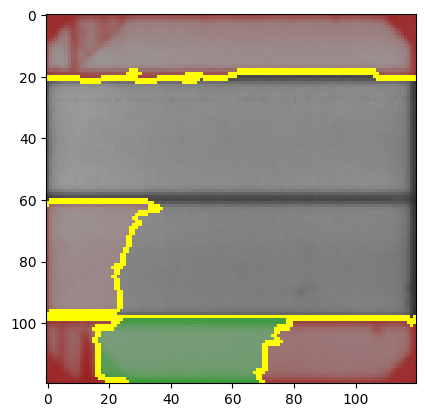

In [39]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_train[10],
         model.predict
)
plt.imshow(X_train[10])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_train[10].reshape((1,120,120,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


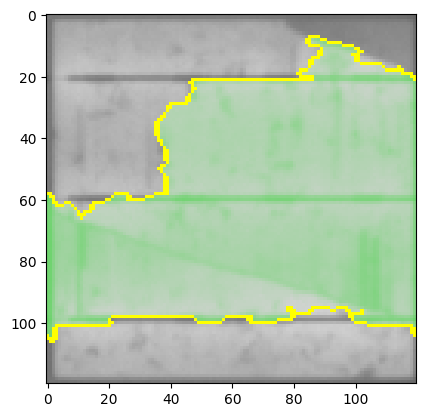

In [40]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_train[0],
         model.predict
)
plt.imshow(X_train[0])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_train[0].reshape((1,120,120,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


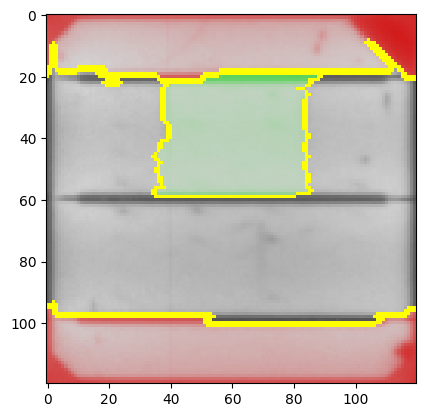

In [41]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_test[3],
         model.predict
)
plt.imshow(X_test[3])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_test[3].reshape((1,120,120,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

In [ ]:
# Testing performance with ResNet - 50

In [ ]:
def create_model():
    resnet_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top = False,
        input_shape = (120,120,3)
    )

    for layer in resnet_model.layers:
        layer.trainable=False

    x = resnet_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64,activation='relu')(x)
    # output layer
    predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)

    res_model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

    # Compiling the model
    res_model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return res_model

In [ ]:
res_model = create_model()

In [ ]:

res_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 126, 126, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 60, 60, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 62, 62, 64)           0         ['conv1_conv[0][0]']          
                                                                                            

In [ ]:
history = res_model.fit(X_train,y_train, batch_size = 16 ,epochs = 10 ,validation_data = (X_test, y_test))

Epoch 1/10
132/132 [==============================] - 14s 42ms/step - loss: 0.0244 - accuracy: 0.9929 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 2/10
132/132 [==============================] - 4s 31ms/step - loss: 9.2212e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 3/10
132/132 [==============================] - 4s 29ms/step - loss: 3.0424e-04 - accuracy: 1.0000 - val_loss: 8.1791e-04 - val_accuracy: 1.0000
Epoch 4/10
132/132 [==============================] - 4s 31ms/step - loss: 1.3071e-04 - accuracy: 1.0000 - val_loss: 6.9146e-04 - val_accuracy: 1.0000
Epoch 5/10
132/132 [==============================] - 3s 26ms/step - loss: 8.8517e-05 - accuracy: 1.0000 - val_loss: 5.6788e-04 - val_accuracy: 1.0000
Epoch 6/10
132/132 [==============================] - 4s 31ms/step - loss: 6.8337e-05 - accuracy: 1.0000 - val_loss: 5.7094e-04 - val_accuracy: 1.0000
Epoch 7/10
132/132 [==============================] - 4s 33ms/step - loss: 5.2702e-05 - accuracy: 1.0000 

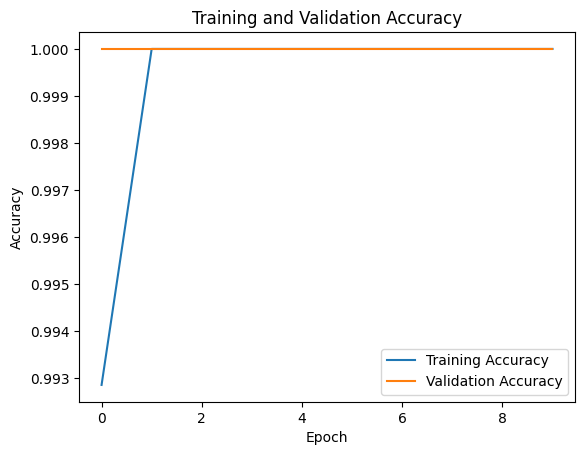

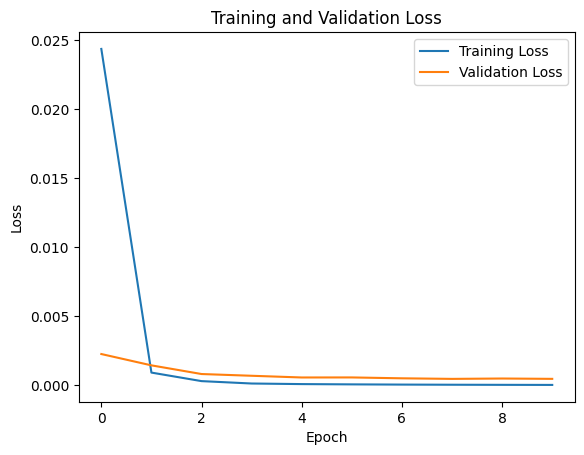

In [ ]:
# Plot the training and validation accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
predictions = res_model.predict(X_test)
predictions = (predictions > 0.5).astype(int)
predictions = predictions.reshape(1, -1)[0]

17/17 [==============================] - 3s 32ms/step


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, predictions, target_names = ['mono','poly']))

              precision    recall  f1-score   support

        mono       1.00      1.00      1.00       216
        poly       1.00      1.00      1.00       309

    accuracy                           1.00       525
   macro avg       1.00      1.00      1.00       525
weighted avg       1.00      1.00      1.00       525



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


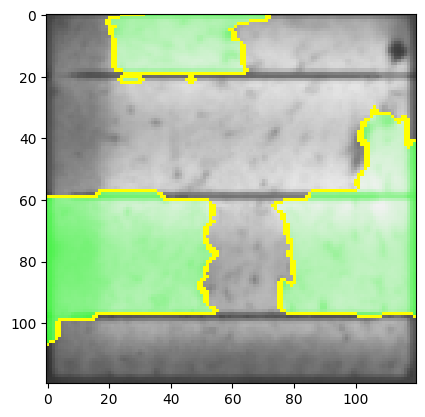

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_train[60],
         res_model.predict
)
plt.imshow(X_train[60])
image, mask = explanation.get_image_and_mask(
         model.predict(
              X_train[60].reshape((1,120,120,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


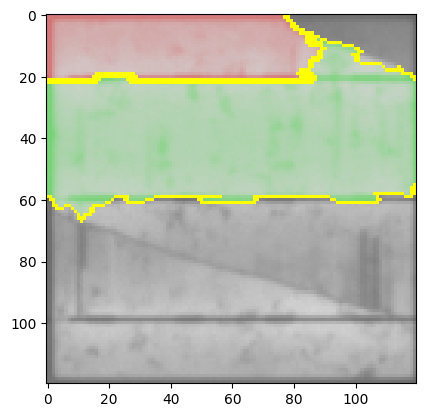

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_train[0],
         res_model.predict
)
plt.imshow(X_train[0])
image, mask = explanation.get_image_and_mask(
         res_model.predict(
              X_train[0].reshape((1,120,120,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 1s 517ms/step


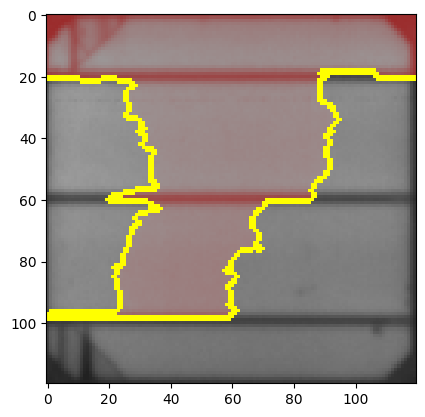

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_train[10],
         res_model.predict
)
plt.imshow(X_train[10])
image, mask = explanation.get_image_and_mask(
         res_model.predict(
              X_train[10].reshape((1,120,120,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


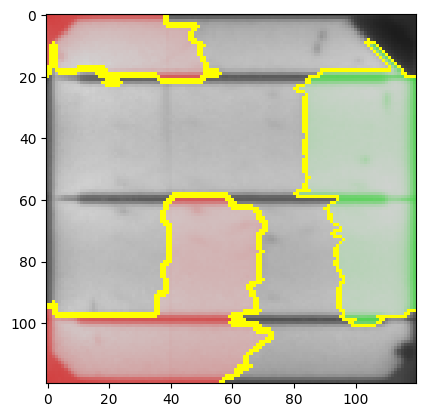

In [ ]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_test[3],
         res_model.predict
)
plt.imshow(X_test[3])
image, mask = explanation.get_image_and_mask(
         res_model.predict(
              X_test[3].reshape((1,120,120,3))
         ).argmax(axis=1)[0],
         positive_only=False,
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

###CLASSIFYNG BASED ON PROBAB

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( images, proba, test_size=0.2, random_state=42)

In [ ]:

X_train = X_train.reshape((-1,120,120,1)).astype('float32') / 255.0
X_test = X_test.reshape((-1,120,120,1)).astype('float32') / 255.0

In [ ]:

import numpy as np
def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 120,120, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb
X_train = to_rgb(X_train)
X_test = to_rgb(X_test)

In [ ]:

X_train.shape

(2099, 120, 120, 3)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

In [ ]:

model = Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


model.add(Flatten())
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4 , activation = 'softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 120, 120, 32)      896       
                                                                 
 batch_normalization_16 (Ba  (None, 120, 120, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 60, 60, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 batch_normalization_17 (Ba  (None, 60, 60, 32)        128       
 tchNormalization)                                               
                                                      

In [ ]:
# Compile the model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
model.compile(optimizer='Adam' , loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])


In [ ]:
history = model.fit(X_train,y_train, batch_size = 32 ,epochs = 25 ,validation_data = (X_test, y_test))

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


66/66 [==============================] - 5s 35ms/step - loss: 0.8568 - accuracy: 0.5970 - val_loss: 7.6189 - val_accuracy: 0.0000e+00
Epoch 2/25
66/66 [==============================] - 1s 21ms/step - loss: 0.5239 - accuracy: 0.6374 - val_loss: 3.5768 - val_accuracy: 0.0000e+00
Epoch 3/25
66/66 [==============================] - 1s 22ms/step - loss: 0.4932 - accuracy: 0.6570 - val_loss: 1.1088 - val_accuracy: 0.5790
Epoch 4/25
66/66 [==============================] - 1s 22ms/step - loss: 0.4468 - accuracy: 0.6675 - val_loss: 1.5481 - val_accuracy: 0.4038
Epoch 5/25
66/66 [==============================] - 1s 19ms/step - loss: 0.4752 - accuracy: 0.6641 - val_loss: 1.3119 - val_accuracy: 0.5505
Epoch 6/25
66/66 [==============================] - 1s 19ms/step - loss: 0.4505 - accuracy: 0.6713 - val_loss: 0.7535 - val_accuracy: 0.5962
Epoch 7/25
66/66 [==============================] - 1s 19ms/step - loss: 0.4448 - accuracy: 0.6679 - val_loss: 0.8280 - val_accuracy: 0.4533
Epoch 8/25
66/66

KeyboardInterrupt: ignored

In [ ]:
print("Accuracy of the model is - " , res_model.evaluate(X_test,y_test)[1]*100 , "%")

17/17 [==============================] - 1s 37ms/step - loss: 8.6911 - accuracy: 0.3657
Accuracy of the model is -  36.571428179740906 %


In [ ]:
predictions = model.predict(X_test)


17/17 [==============================] - 0s 6ms/step


In [ ]:
predictions

array([[9.8775089e-01, 1.2249103e-02, 1.2362564e-12, 8.2477171e-11],
       [9.9840659e-01, 1.5933849e-03, 1.3721958e-18, 4.4380457e-17],
       [9.7829038e-01, 2.1709666e-02, 2.9083300e-10, 6.4884570e-11],
       ...,
       [9.9088973e-01, 9.1102226e-03, 1.5503401e-11, 1.1032857e-15],
       [9.0655291e-01, 9.3435436e-02, 1.0192545e-05, 1.4593930e-06],
       [7.0544106e-01, 2.5189969e-01, 2.2169165e-02, 2.0489994e-02]],
      dtype=float32)

In [ ]:
predicted_classes = []
for i in predictions:
  predicted_classes.append(np.argmax(i))
#predicted_classes = np.argmax(predictions,axis = 1)
predicted_classes = np.array(predicted_classes)
predicted_classes

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,

In [ ]:

predicted_classes = np.argmax(predictions, axis=1)
for i in predicted_classes:
  if i == 0:
    i = 0.
  elif i == 1:
    i = 0.33333333
  elif i == 2:
    i = 0.66666667
  else:
    i = 1.


In [ ]:
predicted_classes.shape

(525,)

In [ ]:
predicted_classes

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, predicted_classes, target_names = ['No','Maybe','Mostly','Defective']))


ValueError: ignored